In [11]:
from functools import reduce
import struct
import numpy as np
import cv2
import datetime
#import helpers # helper functions
import os
import glob # library for loading images from a directory  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sample_types import CommandCode
from sample_types import ResponseCode
from sample_types import Color
from SerialInterface import SerialInterface

VIDEO_STREAM_MODE = False
# 座標IDとピクセル座標の連想リスト(ピクセル座標はカメラ位置に応じて調整して下さい)
#dots = {   1 : (750, 267),  2 : (875, 267),  3 : (1000, 267),  4 : (1125, 267),   5 : (753, 367),  6 : (885, 367),  7 : (1015, 367),  8 : (1150, 367),   9 : (755, 481), 10 : (897, 481), 11 : (1037, 481), 12 : (1174, 481),  13 : (761, 604), 14 : (908, 604), 15 : (1055, 604), 16 : (1200, 604) }
dots = {   1 : (600, 100),  2 : (800, 100),  3 : (1000, 100),  4 : (1200, 100),   5 : (600, 300),  6 : (800, 300),  7 : (1000, 300),  8 : (1200, 300),   9 : (600, 500), 10 : (800, 500), 11 : (1000, 500), 12 : (1200, 500),  13 : (600, 700), 14 : (800, 700), 15 : (1000, 700), 16 : (1200, 700) }
points = dots.values() # 全サークル分の座標リストを作る

num_xy = [[355, 480],[450,365]]
block_xy = [
    [[480, 350],[550,295]],
    [[605, 340],[670,295]],
    [[720, 340],[780,295]],
    [[835, 340],[895,295]],
    
    [[550, 400],[610,350]],
    [[670, 400],[740,355]],
    [[790, 400],[860,360]],
    
    [[480, 450],[540,410]],
    [[605, 450],[660,410]],
    [[720, 460],[780,415]],
    [[840, 460],[900,415]],
        
    [[550, 500],[615,450]],
    [[790, 510],[860,470]],

    [[480, 560],[540,515]],
    [[605, 560],[660,515]],
    [[720, 560],[785,525]],
    [[840, 560],[900,515]],

    [[560, 615],[610,560]],
    [[680, 615],[740,565]],
    [[800, 615],[860,570]],

    [[480, 670],[540,625]],
    [[605, 670],[660,625]],
    [[720, 670],[785,635]],
    [[840, 670],[900,625]]
]


In [12]:
if VIDEO_STREAM_MODE:
    print("capture image from video stream")
else:
    print("read image from file")

read image from file


In [13]:
def load_image_set(image_dir):

    # Populate this empty image list                                                                    
    im_list = []
    # Iterate through each image file in each image_type folder                                         
    # glob reads in any image with the extension "image_dir/im_type/*"                                  
    for file in glob.glob(os.path.join(image_dir,"*")):

        # Read in the image                                                                             
        im = mpimg.imread(file)

        # Check if the image exists/if it's been correctly read-in                                      
        if not im is None:
            # Append the image, and it's type (red, green, yellow) to the image list                    
            im_list.append(im)

    return im_list


In [14]:
def capture_frame():
    # Raspberry Pi3（Webサーバ）のURL
    # http://(Raspberry Pi3のIPアドレス)/?action=stream
    URL = "http://192.168.11.100/?action=stream"
    
    # VideoCaptureのインスタンスを作成する。
    # 引数でカメラを選べれる。
    cap = cv2.VideoCapture(URL)

    # カメラFPSを30FPSに設定
    cap.set(cv2.CAP_PROP_FPS, 30)

    # カメラ画像の横幅を1280に設定
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)

    # カメラ画像の縦幅を720に設定
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
   # 表示するWindow名を設定
    WINDOW_NAME = "camera"
    cv2.namedWindow(WINDOW_NAME)
    

    ret, img = cap.read()
    cv2.imwrite('snapshot_{0:%Y%m%d_%H%M%S}.jpg'.format(datetime.datetime.now()), img)
    
    while cap.isOpened():
        ret, img = cap.read()
        
        #for (x, y) in points:
        #   pixelValue = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[y, x]
        # 色判定
        #  col = Color.getColor(pixelValue) # HSVから色コードへ変換
        #  result.append((x, y, col)) # (x座標,y座標,色)タプルをリストへ追加
        
        # 色情報を画像へ付加
        # dot_num = [k for k, v in dots.items() if (x == v[0] and y == v[1])][0]
        # H = str(pixelValue[0])
        # S = str(pixelValue[1])
        # V = str(pixelValue[2])
        #cv2.circle(img,(x, y), 3, (255,255,255), -1)
        #cv2.putText(img, ("[%d]:" % dot_num) + Color.toColorName(col), (x+10, y+5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
        #cv2.putText(img, H+","+S+","+V, (x+10, y+25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
        
        #guid for calibration
        circle_size = 20
        cv2.circle(img,(148, 286), circle_size, (255,0,0), -1) #RU of number area
        cv2.circle(img,(135, 628), circle_size, (255,0,0), -1)#LL of number area

        cv2.circle(img,(420, 420), circle_size, (255,0,0), -1)#RL of number area
        cv2.circle(img,(205, 212), circle_size, (255,0,0), -1)#LU of block area
        cv2.circle(img,(650, 25), circle_size, (255,0,0), -1)  #RU of block area
        cv2.circle(img,(1030, 516), circle_size, (255,0,0), -1)  #LL of block area
        cv2.circle(img,(1212, 140), circle_size, (255,0,0), -1)  #RL of block area
        # フレームを表示する
        cv2.imshow(WINDOW_NAME, img)
        
        key = cv2.waitKey(1)&0xff
        
        if key == ord('q'):
            # 画像をJPEGファイルへ保存(座標の調整用途)
            cv2.imwrite('snapshot_{0:%Y%m%d_%H%M%S}.jpg'.format(datetime.datetime.now()), img)
            break
            
        cap.release()
        cv2.destroyAllWindows()
      #  del mouseData
    else:
        print("read img")
        WINDOW_NAME = "img"
        img_DIR   = "img_fukuyama/"
        img_LIST = load_img_set(img_DIR)
        img = img_LIST[0]
        #plt.imshow(img)
        
  
    return img



In [15]:
def persipective_image(image):
    # 画像読み込み
    size = tuple(np.array([image.shape[1], image.shape[0]]))
 
    # 図のpersipective1の座標を指定
    perspective1 = np.float32([[0, 720],
                              [1280, 720],
                              [1280,0],
                              [0, 0]])
 
    # 図のpersipective2の座標を指定
    perspective2 = np.float32([[317, 489],
                              [480, 720],
                              [1228, 661],
                              [642, 0]])
 
    # 透視変換行列を生成
    psp_matrix = cv2.getPerspectiveTransform(perspective1,perspective2)
 
    # 透視変換を行い、出力
    img_psp = cv2.warpPerspective(image, psp_matrix, size)
 
    # 変換後の画像をimageディレクトリ配下に保存
    #cv2.imwrite("./image/hanabi_psp.jpg", img_psp)
    #plt.imshow(img_psp)
    
    return img_psp

In [16]:
def standardize_input(image):
    
    ## Resize image and pre-process so that all "standard" images are the same size  
    #standard_im = np.copy(image)
    standard_im = cv2.resize(image, (28, 28))
    return standard_im

In [17]:
def triming_image(image):
    block_img = []

    num_img = img_psp[num_xy[1][1] :num_xy[0][1], num_xy[0][0]: num_xy[1][0]]
    num_img = standardize_input(num_img)
    for i in range (len(block_xy)):
        triming_img = image[block_xy[i][1][1] : block_xy[i][0][1], block_xy[i][0][0] : block_xy[i][1][0]]
        std_img = standardize_input(triming_img)
        block_img.append(std_img )

    return num_img, block_img

In [18]:
IMAGE_DIR   = "image_fukuyama/"
image_list = load_image_set(IMAGE_DIR)
image = image_list[1]

#plt.imshow(image)
img_psp = persipective_image(image)

#For DEBUG
#mark for studying triming position
circle_size = 5
num_xy = [[355, 480],[450,365]]
cv2.circle(img_psp,(num_xy[0][0], num_xy[0][1]), circle_size, (255,0,0), -1) #LL of number area
cv2.circle(img_psp,(num_xy[1][0], num_xy[1][1]), circle_size, (255,0,0), -1) #RU of number area

for i in range (len(block_xy)):
    if i < 4:
        rgb = [255,0,0]
    elif i < 7:
        rgb = [0,255,0]
    elif i < 11:
        rgb = [0,0,255]    

    elif i < 13:
        rgb = [0,255,0]
    
    elif i < 17:
        rgb = [255,0,0]

    elif i < 20:
        rgb = [0,255,0]
    
    elif i < 23:
        rgb = [0,0,255]

    else:
        rgb = [255,255,255]
        
    cv2.circle(img_psp,(block_xy[i][0][0], block_xy[i][0][1]), circle_size, (rgb), -1) #LL of number area
    cv2.circle(img_psp,(block_xy[i][1][0], block_xy[i][1][1]), circle_size, (rgb), -1) #RU of number area
    
plt.figure(figsize=(12, 20))
plt.imshow(img_psp)

720


/Users/KaoruOta/anaconda3/envs/tensorflow_py35/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys


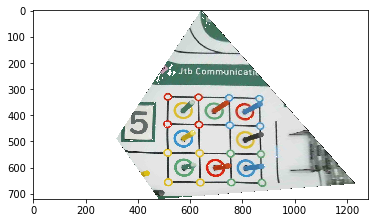

In [19]:
#temporary
image = img_psp
print(image.shape[0])

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        rgb_sum = image[i][j][0] + image[i][j][1] +  image[i][j][2]
        if rgb_sum == 0:
            image[i][j][0] = 255
            image[i][j][1] = 255
            image[i][j][2] = 255
            
plt.imshow(image)

In [20]:
block_img = []
num_img, block_img = triming_image(img_psp)

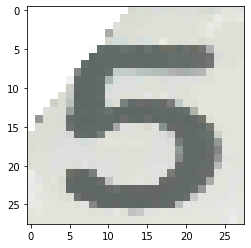

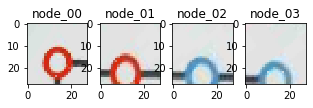

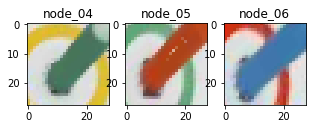

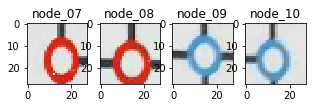

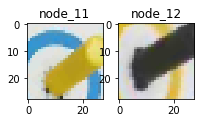

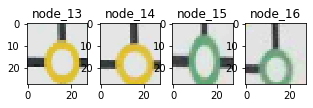

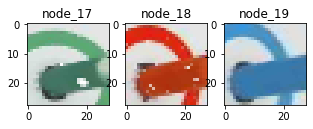

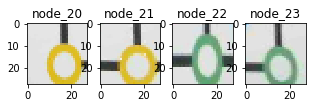

In [21]:
#plot triming and standardized image
plt.imshow(num_img)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5,5))
ax1.set_title('node_00')
ax1.imshow(block_img[0])
ax2.set_title('node_01')
ax2.imshow(block_img[1])
ax3.set_title('node_02')
ax3.imshow(block_img[2])
ax4.set_title('node_03')
ax4.imshow(block_img[3])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5,5))
ax1.set_title('node_04')
ax1.imshow(block_img[4])
ax2.set_title('node_05')
ax2.imshow(block_img[5])
ax3.set_title('node_06')
ax3.imshow(block_img[6])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5,5))
ax1.set_title('node_07')
ax1.imshow(block_img[7])
ax2.set_title('node_08')
ax2.imshow(block_img[8])
ax3.set_title('node_09')
ax3.imshow(block_img[9])
ax4.set_title('node_10')
ax4.imshow(block_img[10])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(3,3))
ax1.set_title('node_11')
ax1.imshow(block_img[11])
ax2.set_title('node_12')
ax2.imshow(block_img[12])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5,5))
ax1.set_title('node_13')
ax1.imshow(block_img[13])
ax2.set_title('node_14')
ax2.imshow(block_img[14])
ax3.set_title('node_15')
ax3.imshow(block_img[15])
ax4.set_title('node_16')
ax4.imshow(block_img[16])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5,5))
ax1.set_title('node_17')
ax1.imshow(block_img[17])
ax2.set_title('node_18')
ax2.imshow(block_img[18])
ax3.set_title('node_19')
ax3.imshow(block_img[19])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5,5))
ax1.set_title('node_20')
ax1.imshow(block_img[20])
ax2.set_title('node_21')
ax2.imshow(block_img[21])
ax3.set_title('node_22')
ax3.imshow(block_img[22])
ax4.set_title('node_23')
ax4.imshow(block_img[23])